# Dataset analysis
Understanding the data is essential part of creating models that perform well. We can understand data through data analysis.

In [1]:
# import keras_tuner as kt
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
import seaborn as sns
import tensorflow as tf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,PM10 Concentration,PM10 Unit,DatetimeBegin,DatetimeEnd,PM2.5 Concentration,PM2.5 Unit,CO Concentration,CO Unit,NO2 Concentration,NO2 Unit,SO2 Concentration,SO2 Unit,C6H6 Concentration,C6H6 Unit
0,38.942,µg/m3,2018-01-01 00:00:00 +01:00,2018-01-01 01:00:00 +01:00,46.409,µg/m3,0.46168,mg/m3,21.6056,µg/m3,5.36549,µg/m3,1.10825,µg/m3
1,52.889,µg/m3,2018-01-01 01:00:00 +01:00,2018-01-01 02:00:00 +01:00,53.467,µg/m3,0.43268,mg/m3,21.1869,µg/m3,NaN,NaN,0.93600,µg/m3
2,37.007,µg/m3,2018-01-01 02:00:00 +01:00,2018-01-01 03:00:00 +01:00,37.668,µg/m3,0.39208,mg/m3,16.2845,µg/m3,5.14364,µg/m3,0.69225,µg/m3
3,35.837,µg/m3,2018-01-01 03:00:00 +01:00,2018-01-01 04:00:00 +01:00,37.333,µg/m3,0.38628,mg/m3,17.3246,µg/m3,5.16466,µg/m3,0.59800,µg/m3
4,34.408,µg/m3,2018-01-01 04:00:00 +01:00,2018-01-01 05:00:00 +01:00,29.130,µg/m3,0.36308,mg/m3,15.5656,µg/m3,5.23302,µg/m3,0.57200,µg/m3


In [3]:
print(f'Number of rows: {len(df)}')

Number of rows: 26305


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PM10 Concentration,25956.0,22.392300,14.358808,0.002600,12.415750,19.768500,28.975500,353.12000
PM2.5 Concentration,25728.0,14.541749,12.478324,0.012200,5.852625,10.847500,19.669000,118.52000
CO Concentration,25640.0,0.384108,0.165666,0.041760,0.265060,0.344636,0.467016,3.29904
NO2 Concentration,25650.0,31.520344,20.845578,1.100930,15.093450,27.236400,43.630850,145.59900
SO2 Concentration,25155.0,4.601444,9.877013,-3.835720,0.875406,3.309310,7.006040,657.84500
C6H6 Concentration,25727.0,1.008329,1.376376,0.000975,0.331500,0.674375,1.496950,109.64200


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

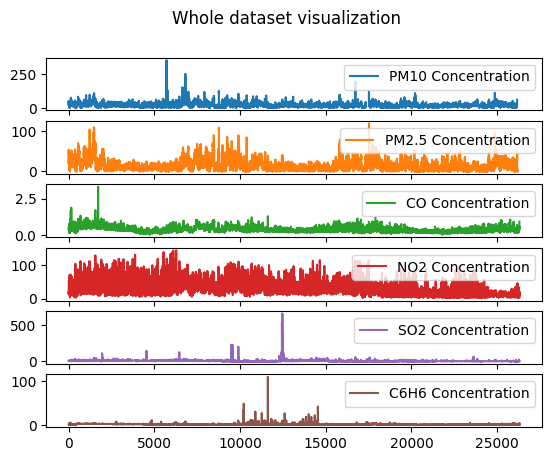

In [5]:
df.plot(subplots=True, title='Whole dataset visualization')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

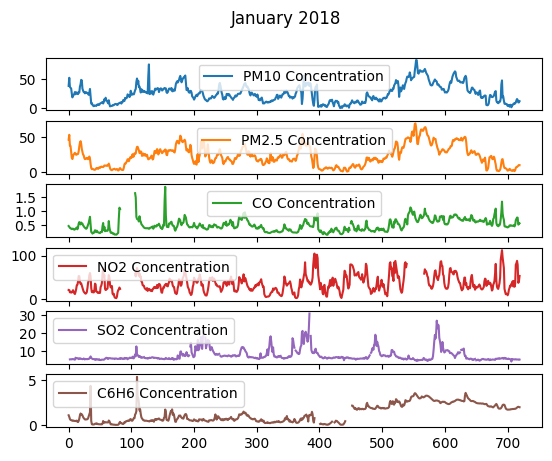

In [6]:
df[:720].plot(subplots=True, title='January 2018')

array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

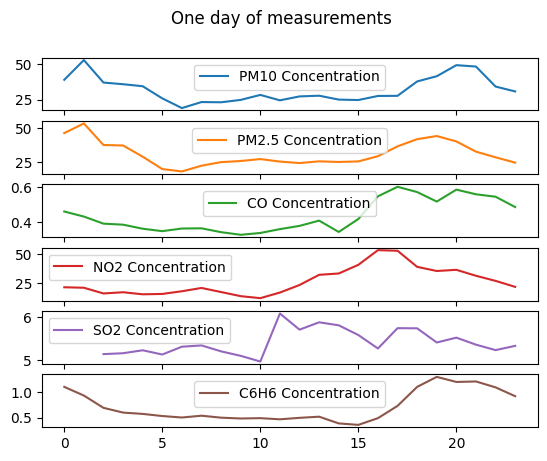

In [7]:
df[:24].plot(subplots=True, title='One day of measurements')

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

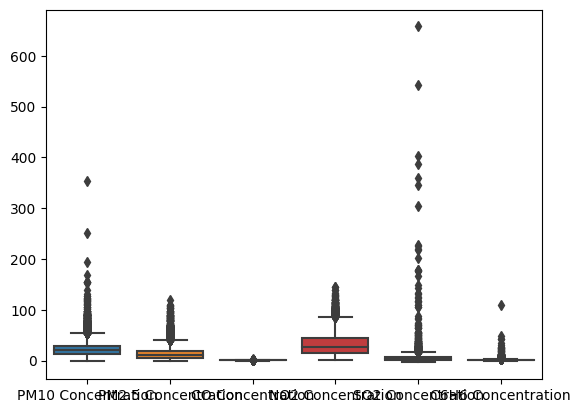

In [8]:
sns.boxplot(data=df)

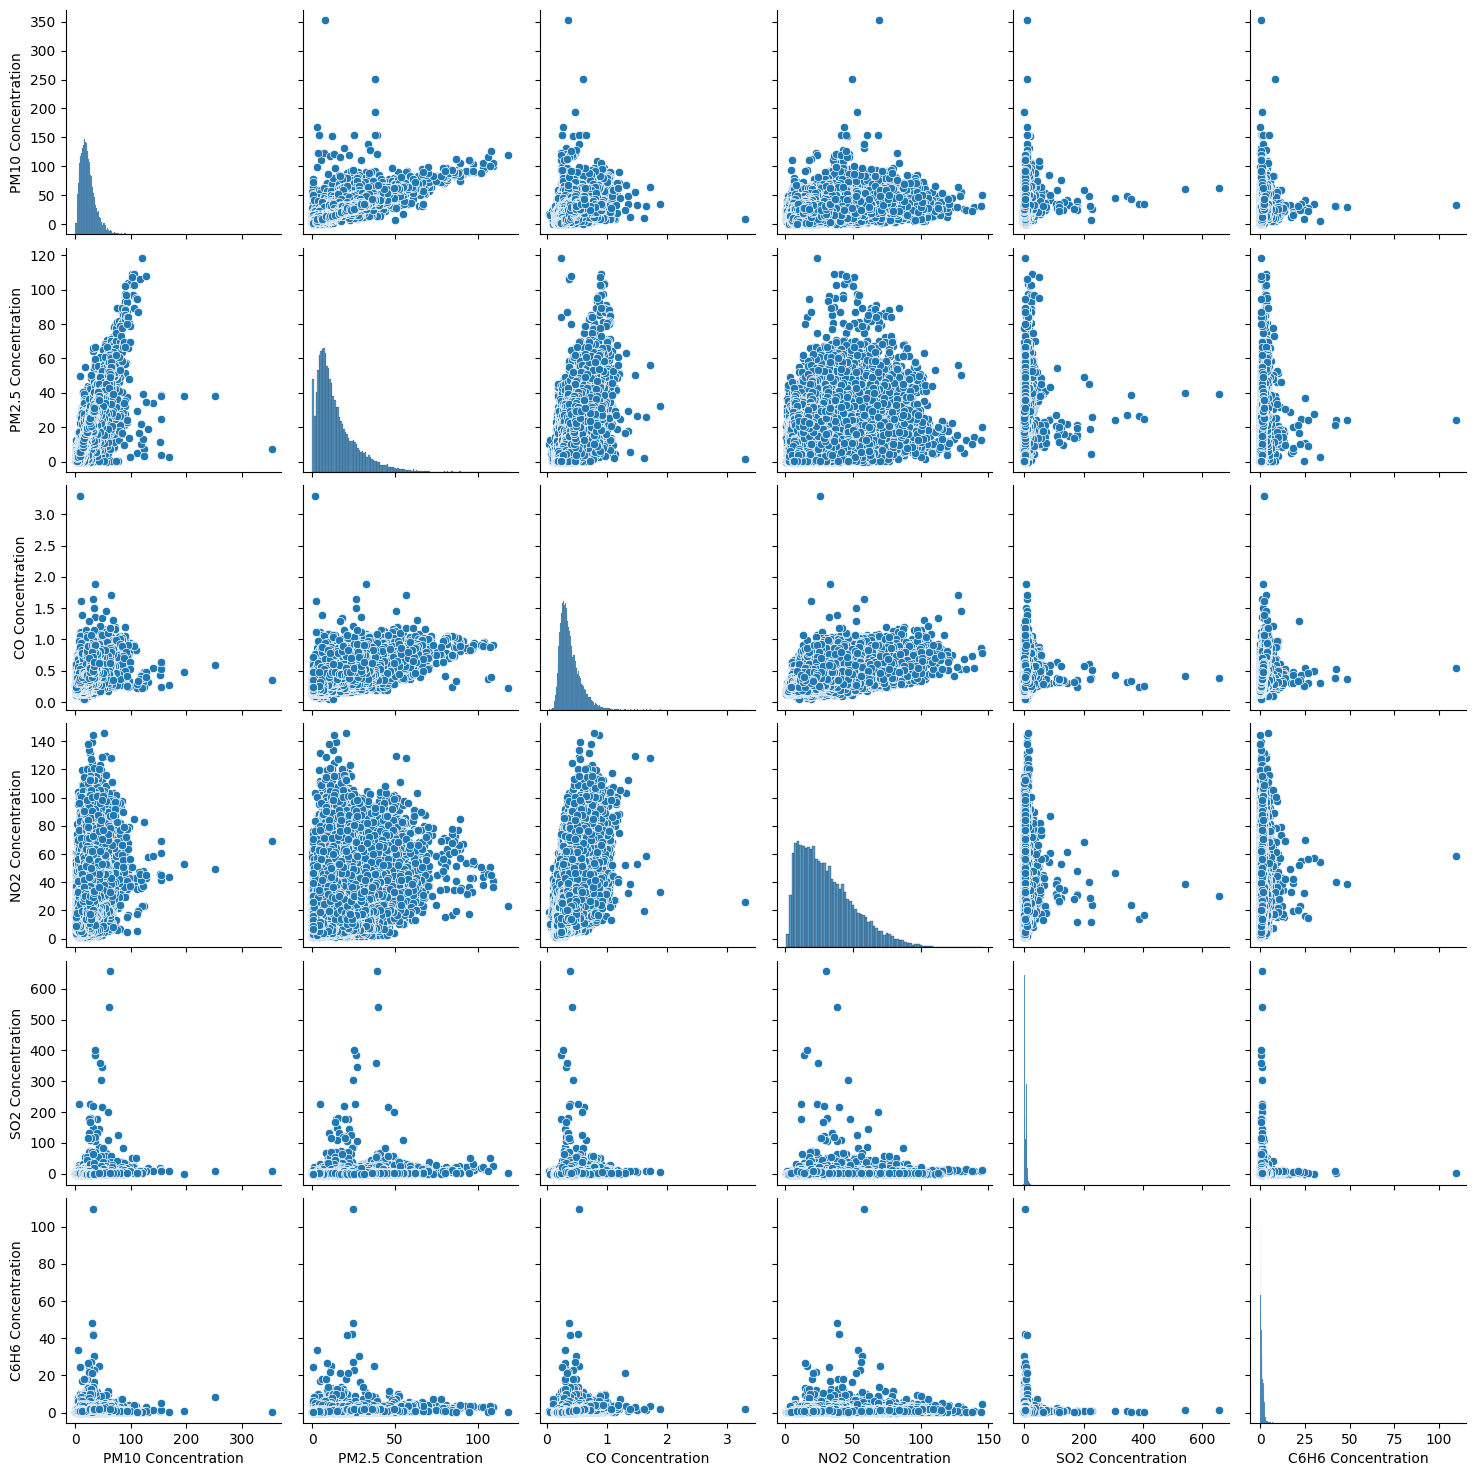

In [9]:
sns.pairplot(data=df)

In [10]:
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']].corr(method='pearson')

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
PM10 Concentration,1.000000,0.791429,0.517186,0.340900,0.173231,0.252359
PM2.5 Concentration,0.791429,1.000000,0.614492,0.238039,0.124964,0.269209
CO Concentration,0.517186,0.614492,1.000000,0.602560,0.096733,0.377680
NO2 Concentration,0.340900,0.238039,0.602560,1.000000,0.134214,0.247135
SO2 Concentration,0.173231,0.124964,0.096733,0.134214,1.000000,0.073409
C6H6 Concentration,0.252359,0.269209,0.377680,0.247135,0.073409,1.000000


<AxesSubplot: >

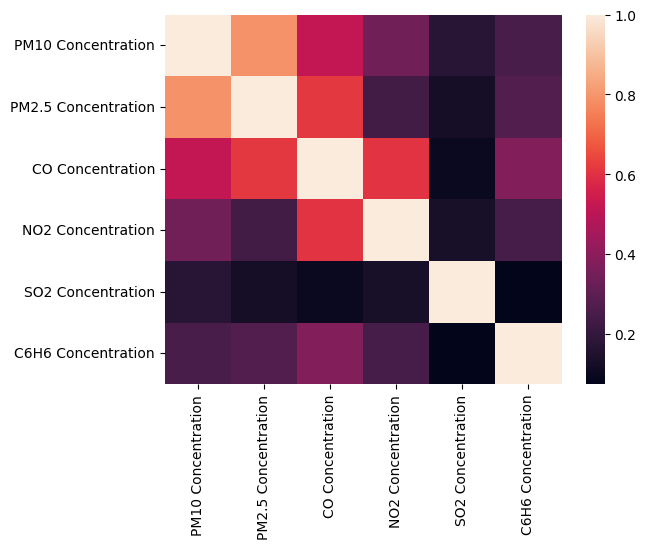

In [11]:
sns.heatmap(data=df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']].corr(method='pearson'))

The table shows that correlation coefficient between any pair of measured data is considerably strong. This means our data is related. We can see particularly strong correlation between PM10 and PM2.5 particles and PM2.5 particles and CO concentration.

In [12]:
nan_rows = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1) > 0)
print(f'Number of rows containing NaN is {nan_rows}/{len(df)} or {round(nan_rows / len(df) * 100, 3)} %')

Number of rows containing NaN is 3052/26305 or 11.602 %


# Data cleaning

#### Time-series cleaning

In [13]:
def timeCleaning(x):
    return x.rsplit(' ', 1)[0]
df['DatetimeBegin'] = df['DatetimeBegin'].apply(timeCleaning)
df.drop(columns='DatetimeEnd', inplace=True)

#### NaN imputing

In [14]:
df.drop(['PM10 Unit', 'PM2.5 Unit', 'CO Unit', 'NO2 Unit', 'SO2 Unit', 'C6H6 Unit'], inplace=True, axis=1)
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']])
df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']] = imputer.transform(df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration', 'SO2 Concentration', 'C6H6 Concentration']])
df

,PM10 Concentration,DatetimeBegin,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
0,38.942000,2018-01-01 00:00:00,46.409000,0.461680,21.605600,5.365490,1.108250
1,52.889000,2018-01-01 01:00:00,53.467000,0.432680,21.186900,7.363020,0.936000
2,37.007000,2018-01-01 02:00:00,37.668000,0.392080,16.284500,5.143640,0.692250
3,35.837000,2018-01-01 03:00:00,37.333000,0.386280,17.324600,5.164660,0.598000
4,34.408000,2018-01-01 04:00:00,29.130000,0.363080,15.565600,5.233020,0.572000
...,...,...,...,...,...,...,...
26300,20.642903,2020-10-19 15:00:00,13.122164,0.361663,29.192009,0.637868,0.628225
26301,21.812805,2020-10-20 17:00:00,14.244807,0.383440,30.921196,0.841092,1.125800
26302,21.234059,2020-03-29 22:00:00,13.375752,0.361133,29.743226,4.367483,0.516425
26303,22.205407,2020-05-15 12:00:00,14.307335,0.379205,31.180601,4.568202,0.929500


In [15]:
df_timestamps = pd.to_datetime(df.pop('DatetimeBegin'), format='%Y.%m.%d %H:%M:%S')

#### Outlier imputation

c:\Users\Gamebox\Desktop\School\FIIT\BP_time_series_forecasting_cambals\BP_env\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

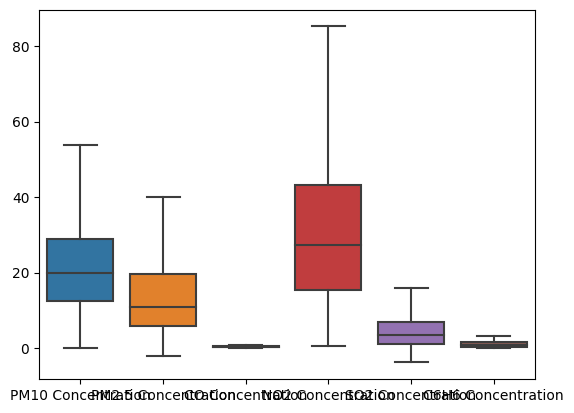

In [16]:
class QuantileOutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def impute(self, data, feature: str):
        # print(f'Imputing outliers for feature: {feature}')
        q25, q75 = np.percentile(data[feature], 25), np.percentile(data[feature], 75)
        iqr = q75 - q25
        # print(f'q25 = {round(q25, 3)}; q75 = {round(q75, 3)}; IQR = {round(iqr, 3)}')
        cutoff = round(iqr * 1.5, 5)
        lower, upper = q25 - cutoff, q75 + cutoff
        # print('cutoff=', round(cutoff, 3), 'lower=', round(lower, 3), 'upper=', round(upper, 3), '\n')
        q5, q95 = np.percentile(data[feature], 5), np.percentile(data[feature], 95)

        outliers_lower = data[feature] <= lower
        data[feature].mask(outliers_lower, other=q5, axis=0, inplace=True)
        outliers_upper = data[feature] >= upper
        data[feature].mask(outliers_upper, other=q95, axis=0, inplace=True)
        return data

    def fit(self, X, y=None):
        self.data = X
        self.features = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        return self

    def transform(self, X, y=None):
        cols = [x for x in df.columns if x not in ['longitude', 'latitude', 'TEMP', 'PRES', 'warning']]
        for feature in cols:
            self.data = self.impute(self.data, feature)
        return self.data

outlier_imputer = QuantileOutlierImputer()
df = outlier_imputer.fit_transform(df)
sns.boxplot(data=df)

## Augmented Dickey-Fuller (ADF) unit root test
Augmented Dickey-Fuller (ADF) unit root test is defined as follows:
- $H_0$: the data possesses a unit root (random walk) and it is non-stationary.
- $H_a$: the data is stationary.

Result intepretation:
- if ADF statistic test < 1% 5% 10% (Critical Values) then $H_0$ is rejected
- if P-Value < 0.05 then $H_0$ is rejected 

In [17]:
cols_selected = []
for col in df.columns:
    missing = df[col].isnull().sum()
    if not missing:
        dftest = adfuller(df[col], autolag = 'AIC')
        if (dftest[1] < 0.05) and (dftest[2] > 3):
            cols_selected.append(col)
            print(col, '  ADF val: ', dftest[0], '\tp-value: ', dftest[1], '\tNum of lags: ', dftest[2])

PM10 Concentration   ADF val:  -13.112281980157404 	p-value:  1.6255791729309529e-24 	Num of lags:  48
PM2.5 Concentration   ADF val:  -11.312823687566896 	p-value:  1.2270193600409791e-20 	Num of lags:  49
CO Concentration   ADF val:  -9.160084881991539 	p-value:  2.5469464851964914e-15 	Num of lags:  49
NO2 Concentration   ADF val:  -9.987045131884857 	p-value:  2.0424049284332727e-17 	Num of lags:  49
SO2 Concentration   ADF val:  -5.466409384646881 	p-value:  2.453219113355593e-06 	Num of lags:  49
C6H6 Concentration   ADF val:  -8.239670355957323 	p-value:  5.762446520887207e-13 	Num of lags:  49


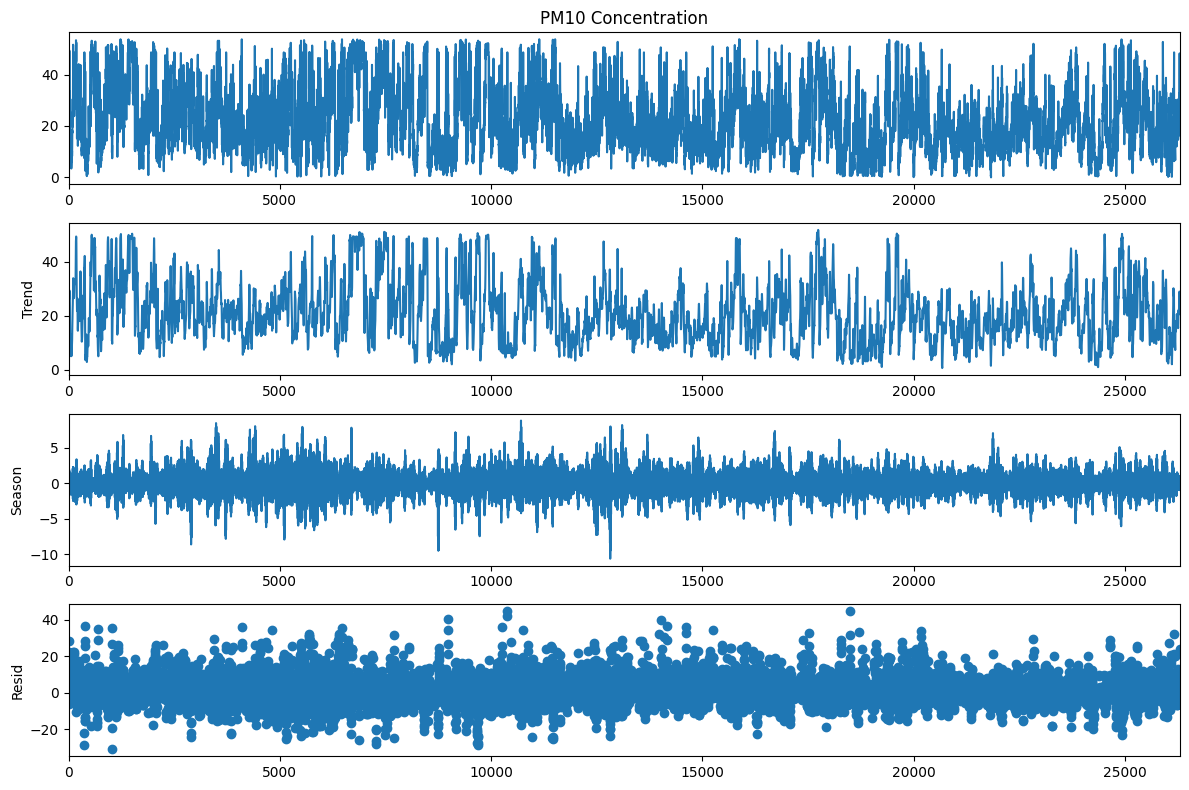

In [18]:
result_pm10 = STL(df['PM10 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result_pm10.plot()
plt.show()
# data_cleaned = result.trend.reshape(-1, 1)

In [19]:
result_pm25 = STL(df['PM2.5 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
# result_pm25.plot()
# plt.show()

In [20]:
result_co = STL(df['CO Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
# result_co.plot()
# plt.show()

In [21]:
result_no2 = STL(df['NO2 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
# result_no2.plot()
# plt.show()

In [22]:
result_so2 = STL(df['SO2 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
# result_so2.plot()
# plt.show()

In [23]:
result_c6h6 = STL(df['C6H6 Concentration'], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
# result_c6h6.plot()
# plt.show()

In [24]:
cleaned_training_df = pd.DataFrame({
    'PM10 Concentration': result_pm10.trend,
    'PM2.5 Concentration': result_pm25.trend,
    'CO Concentration': result_co.trend,
    'NO2 Concentration': result_no2.trend,
    'SO2 Concentration': result_so2.trend,
    'C6H6 Concentration': result_c6h6.trend,
})
cleaned_training_df.head()

,PM10 Concentration,PM2.5 Concentration,CO Concentration,NO2 Concentration,SO2 Concentration,C6H6 Concentration
0,24.826896,26.019786,0.369785,17.614597,5.211591,0.537017
1,24.825908,25.984320,0.368750,17.588960,5.211224,0.535476
2,24.826556,25.945189,0.367656,17.559050,5.210626,0.533749
3,24.830294,25.903923,0.366464,17.520714,5.209759,0.531888
4,24.839789,25.864980,0.364923,17.467378,5.209020,0.529980


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >], dtype=object)

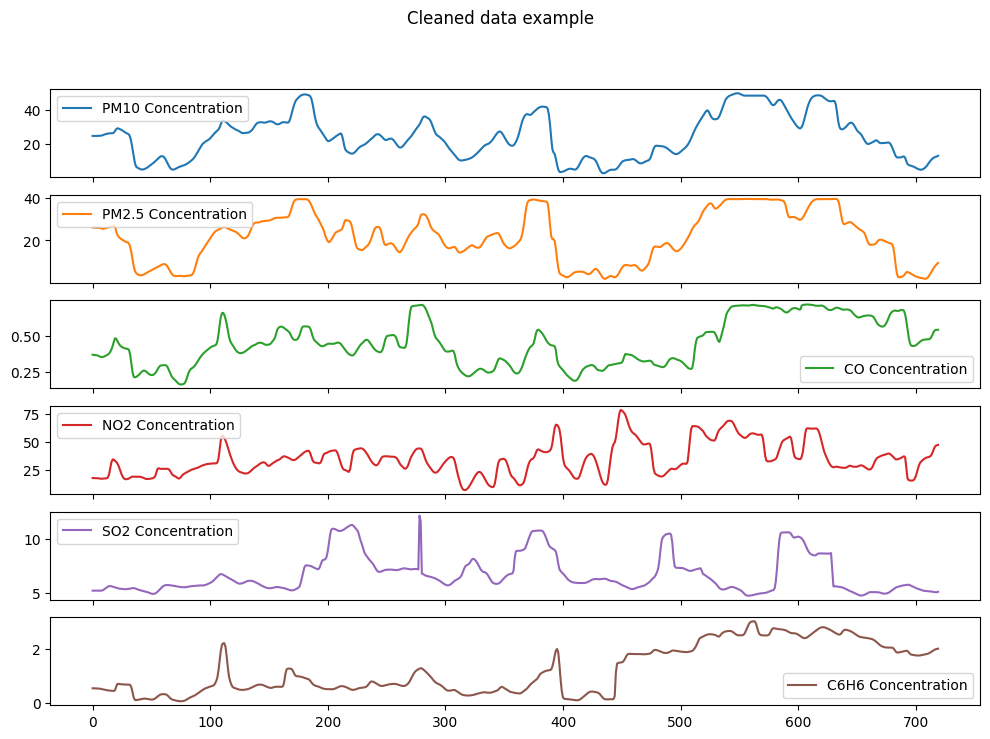

In [25]:
cleaned_training_df[:720].plot(subplots=True, title='Cleaned data example')

#### Omitting features with least impact on learning

In [26]:
df = df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']]
cleaned_training_df = cleaned_training_df[['PM10 Concentration', 'PM2.5 Concentration', 'CO Concentration', 'NO2 Concentration']]

## Data scaling

In [27]:
scaler = MinMaxScaler()
df_original = df.copy()
df = scaler.fit_transform(df)
cleaned_training_df = scaler.transform(cleaned_training_df)

## Data windowing

In [66]:
df_test = cleaned_training_df[int(len(cleaned_training_df)*0.8):]
df_train = cleaned_training_df[0:int(len(cleaned_training_df)*0.8)]

trainX = []
trainY = []

In [67]:
look_back = 24
future_n = 1

for i in range(look_back, len(df_train) - future_n + 1):
    trainX.append(df_train[i - look_back: i, 0: df_train.shape[1]])
    trainY.append(df_train[i + future_n - 1: i + future_n, 0]) # PM10 je zvoleny ako y label

trainX = np.array(trainX)
trainY = np.array(trainY)
print(f'trainX shape: {trainX.shape}; trainY shape: {trainY.shape}')

testX = []
for i in range(look_back, len(df_test)):
    testX.append(df_test[i-look_back: i, 0: df_test.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX shape: (21020, 24, 4); trainY shape: (21020, 1)
testX shape: (5237, 24, 4)


# Experiment n.1:

## Model creation and training

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

model1 = tf.keras.Sequential([
    LSTM(units=64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
    LSTM(units=32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
model1.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17664     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model1.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
1183/1183 [==============================] - 16s 11ms/step - loss: 0.0099 - mean_absolute_error: 0.0694 - root_mean_squared_error: 0.0993 - mean_absolute_percentage_error: 21.2389 - val_loss: 0.0017 - val_mean_absolute_error: 0.0292 - val_root_mean_squared_error: 0.0415 - val_mean_absolute_percentage_error: 15.2709
Epoch 2/20
1183/1183 [==============================] - 12s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0540 - mean_absolute_percentage_error: 11.1923 - val_loss: 0.0017 - val_mean_absolute_error: 0.0327 - val_root_mean_squared_error: 0.0409 - val_mean_absolute_percentage_error: 11.2144
Epoch 3/20
1183/1183 [==============================] - 12s 10ms/step - loss: 0.0019 - mean_absolute_error: 0.0309 - root_mean_squared_error: 0.0441 - mean_absolute_percentage_error: 10.0137 - val_loss: 3.9904e-04 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_percentage_error: 5.9574
Epoch 4/20
11

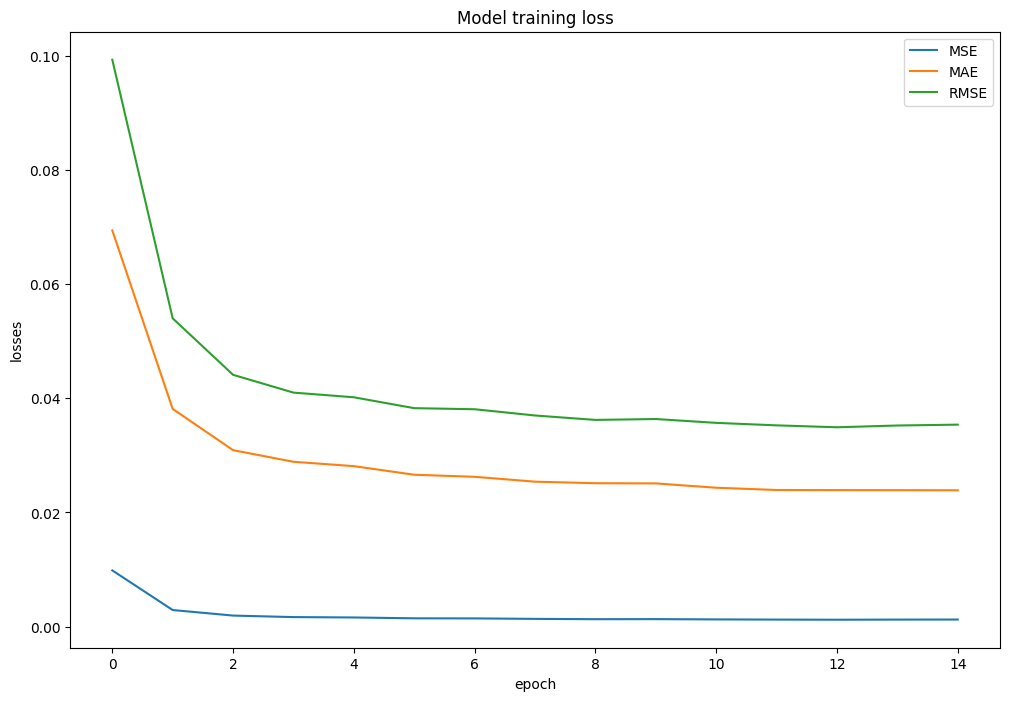

In [32]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

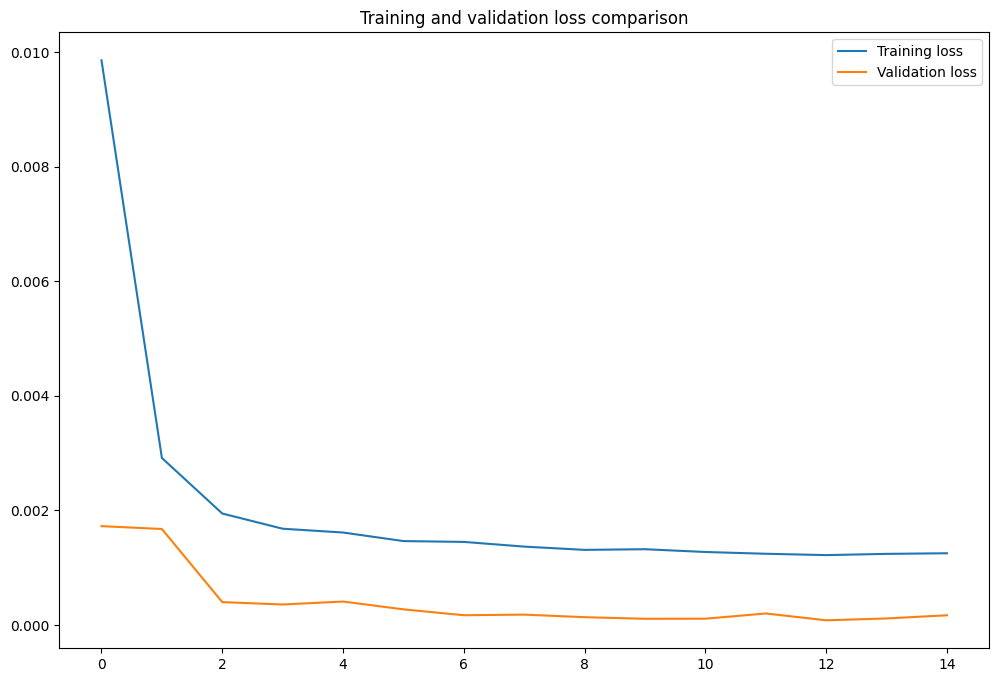

In [33]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss comparison')
plt.legend()

## Predicting with model

In [68]:
hours_to_predict = 24
past_hours = 200

y_pred = model1.predict(testX[-past_hours:])
print(y_pred.shape)
y_pred

7/7 [==============================] - 0s 4ms/step
(200, 1)


array([[0.12312852],
       [0.11103368],
       [0.09510741],
       [0.08295718],
       [0.07019931],
       [0.05799988],
       [0.04916421],
       [0.0440037 ],
       [0.04324767],
       [0.04556453],
       [0.05211934],
       [0.06319574],
       [0.08270192],
       [0.10835844],
       [0.12107113],
       [0.13672502],
       [0.15399486],
       [0.16911389],
       [0.18083212],
       [0.18951821],
       [0.19495448],
       [0.20434627],
       [0.22403884],
       [0.2500165 ],
       [0.25895455],
       [0.25464493],
       [0.26145983],
       [0.2687707 ],
       [0.2728387 ],
       [0.28010696],
       [0.29007977],
       [0.30300918],
       [0.31849834],
       [0.33191365],
       [0.34652075],
       [0.36251214],
       [0.37756786],
       [0.3892751 ],
       [0.40163887],
       [0.42105818],
       [0.45405132],
       [0.49233216],
       [0.5245879 ],
       [0.54369724],
       [0.54811174],
       [0.5415858 ],
       [0.52982694],
       [0.517

### Inverse scaling of predicted values

In [69]:
y_pred = np.repeat(y_pred, df.shape[1], axis=-1)
y_pred = scaler.inverse_transform(y_pred)[:,0]

### Plotting predictions from test set against real measurements

In [70]:
real_data = df_original[int(len(df_original)*0.8):]
real_data = real_data['PM10 Concentration'].to_numpy()[-past_hours:]

In [71]:
from scipy.signal import argrelextrema
extremes = argrelextrema(real_data, np.greater, order=5)

diffs = []
for ex in extremes[0]:
    if y_pred[ex] < real_data[ex]:
        diffs.append(ex)

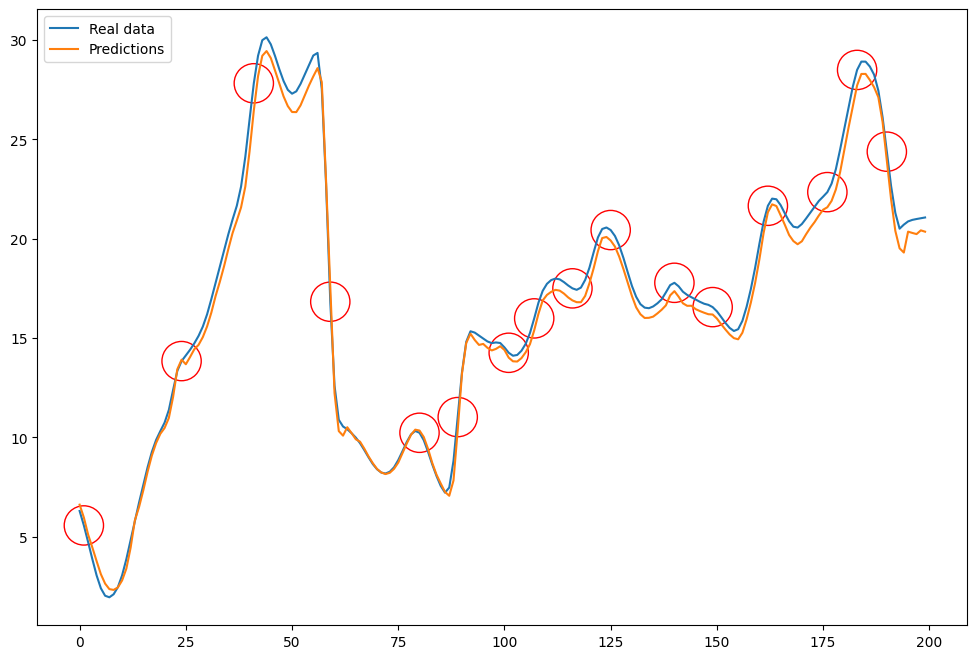

In [73]:
real = df_test[-past_hours:]
real = scaler.inverse_transform(real)[:, 0]

plt.plot(real)
plt.plot(y_pred)
plt.scatter(diffs, real[diffs], facecolors='none', s=800, edgecolors='r')
plt.legend(['Real data', 'Predictions'])
plt.show()

## Model evaluation

### In: Test data (trend, normed)

In [58]:
model1_metrics = dict()
model1_metrics['MAPE'] = mean_absolute_percentage_error(y_pred, real_data)*100
model1_metrics['RMSE'] = math.sqrt(mean_squared_error(y_pred, real_data))
model1_metrics['MAE'] = mean_absolute_error(y_pred, real_data)
model1_metrics

{'MAPE': 18.371593535793465,
 'RMSE': 4.948212424868259,
 'MAE': 2.62862949182467}

### In: Cleaned (trend + seasonal, normed)

In [40]:
test_trend_seasonal = pd.DataFrame({
    'PM10 Concentration': result_pm10.trend + result_pm10.seasonal,
    'PM2.5 Concentration': result_pm25.trend + result_pm25.seasonal,
    'CO Concentration': result_co.trend + result_co.seasonal,
    'NO2 Concentration': result_no2.trend + result_no2.seasonal
})
test_scaler = MinMaxScaler()
test_trend_seasonal = test_scaler.fit_transform(test_trend_seasonal)

In [41]:
df_test = test_trend_seasonal[int(len(test_trend_seasonal)*0.8):]

look_back = 24
future_n = 1

testX = []
for i in range(look_back, len(df_test)):
    testX.append(df_test[i-look_back: i, 0: df_test.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

testX shape: (5237, 24, 4)


In [42]:
past_hours = 200

y_pred = model1.predict(testX[-past_hours:])
print(y_pred.shape)

7/7 [==============================] - 0s 4ms/step
(200, 1)


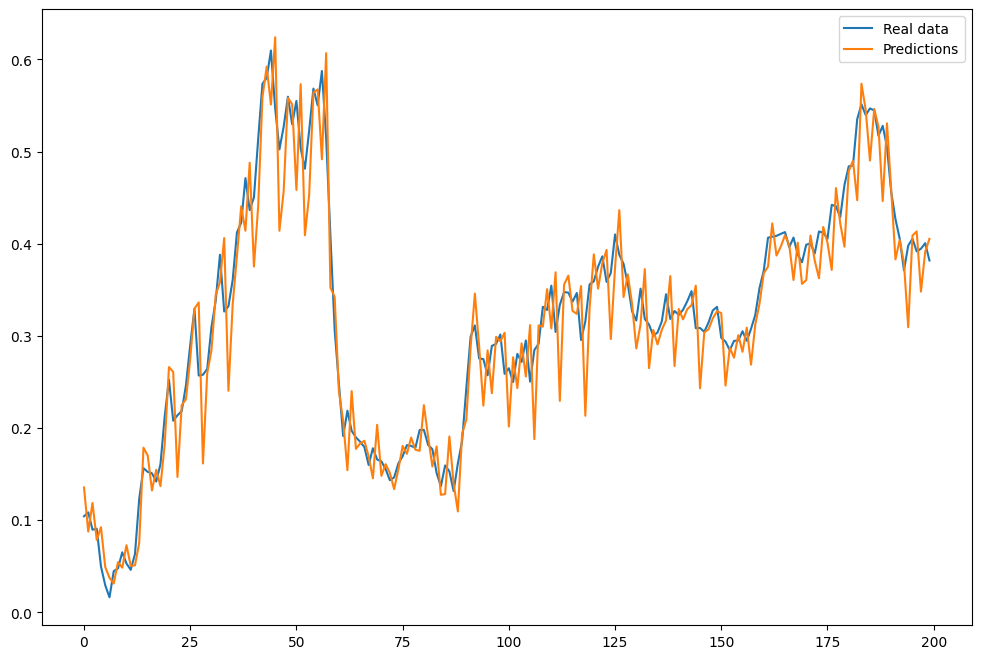

In [43]:
real = df_test[-past_hours:, 0]

plt.plot(real)
plt.plot(y_pred)
plt.legend(['Real data', 'Predictions'])
plt.show()

In [44]:
model1_metrics = dict()
model1_metrics['MAPE'] = mean_absolute_percentage_error(y_pred, real)*100
model1_metrics['RMSE'] = math.sqrt(mean_squared_error(y_pred, real))
model1_metrics['MAE'] = mean_absolute_error(y_pred, real)
model1_metrics

{'MAPE': 12.108469573646875,
 'RMSE': 0.039656523632546035,
 'MAE': 0.030130599041492356}

### In: Raw (trend + seasonal, normed)

In [59]:
result_pm10 = STL(df_original['PM10 Concentration'], period=6, robust = True).fit()
result_pm25 = STL(df_original['PM2.5 Concentration'], period=6, robust = True).fit()
result_no2 = STL(df_original['NO2 Concentration'], period=6, robust = True).fit()
result_co = STL(df_original['CO Concentration'], period=6, robust = True).fit()
test_trend_seasonal = pd.DataFrame({
    'PM10 Concentration': result_pm10.trend + result_pm10.seasonal,
    'PM2.5 Concentration': result_pm25.trend + result_pm25.seasonal,
    'CO Concentration': result_co.trend + result_co.seasonal,
    'NO2 Concentration': result_no2.trend + result_no2.seasonal
})
test_scaler = MinMaxScaler()
test_trend_seasonal = test_scaler.fit_transform(test_trend_seasonal)

In [60]:
df_test = test_trend_seasonal[int(len(test_trend_seasonal)*0.8):]

look_back = 24
future_n = 1

testX = []
for i in range(look_back, len(df_test)):
    testX.append(df_test[i-look_back: i, 0: df_test.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

testX shape: (5237, 24, 4)


In [61]:
past_hours = 200

y_pred = model1.predict(testX[-past_hours:])
print(y_pred.shape)

7/7 [==============================] - 0s 4ms/step
(200, 1)


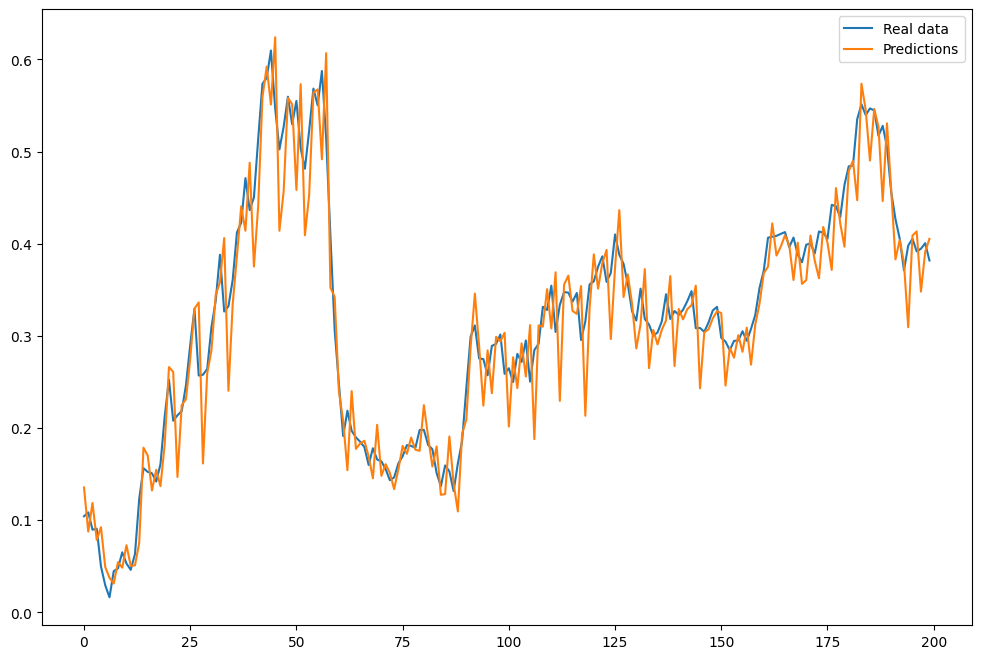

In [62]:
real = df_test[-past_hours:, 0]

plt.plot(real)
plt.plot(y_pred)
plt.legend(['Real data', 'Predictions'])
plt.show()

In [63]:
model1_metrics = dict()
model1_metrics['MAPE'] = mean_absolute_percentage_error(y_pred, real)*100
model1_metrics['RMSE'] = math.sqrt(mean_squared_error(y_pred, real))
model1_metrics['MAE'] = mean_absolute_error(y_pred, real)
model1_metrics

{'MAPE': 12.108469573646875,
 'RMSE': 0.039656523632546035,
 'MAE': 0.030130599041492356}

# Model n.2:
## Model Creation and training

In [49]:
df_test = cleaned_training_df[int(len(cleaned_training_df)*0.8):]
df_train = cleaned_training_df[0:int(len(cleaned_training_df)*0.8)]

trainX = []
trainY = []

In [50]:
look_back = 12
future_n = 1

for i in range(look_back, len(df_train) - future_n + 1):
    trainX.append(df_train[i - look_back: i, 0: df_train.shape[1]])
    trainY.append(df_train[i + future_n - 1: i + future_n, 0]) # PM10 je zvoleny ako y label

trainX = np.array(trainX)
trainY = np.array(trainY)
print(f'trainX shape: {trainX.shape}; trainY shape: {trainY.shape}')

testX = []
for i in range(look_back, len(df_test)):
    testX.append(df_test[i-look_back: i, 0: df_test.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX shape: (21032, 12, 4); trainY shape: (21032, 1)
testX shape: (5249, 12, 4)


In [51]:
model2 = tf.keras.Sequential([
    LSTM(units=64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
    LSTM(units=32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])
model2.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 12, 64)            17664     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [111]:
history = model2.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1)

Epoch 1/30
1183/1183 [==============================] - 19s 13ms/step - loss: 0.0113 - mean_absolute_error: 0.0749 - root_mean_squared_error: 0.1064 - mean_absolute_percentage_error: 23.0211 - val_loss: 0.0027 - val_mean_absolute_error: 0.0374 - val_root_mean_squared_error: 0.0516 - val_mean_absolute_percentage_error: 22.8653
Epoch 2/30
1183/1183 [==============================] - 17s 14ms/step - loss: 0.0043 - mean_absolute_error: 0.0476 - root_mean_squared_error: 0.0659 - mean_absolute_percentage_error: 15.3756 - val_loss: 0.0030 - val_mean_absolute_error: 0.0421 - val_root_mean_squared_error: 0.0545 - val_mean_absolute_percentage_error: 19.8928
Epoch 3/30
1183/1183 [==============================] - 16s 13ms/step - loss: 0.0036 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0597 - mean_absolute_percentage_error: 13.6588 - val_loss: 0.0019 - val_mean_absolute_error: 0.0313 - val_root_mean_squared_error: 0.0431 - val_mean_absolute_percentage_error: 19.4239
Epoch 4/30
1183/

In [112]:
hours_to_predict = 24
past_hours = 200

y_pred = model2.predict(testX[-past_hours:])
print(y_pred.shape)

7/7 [==============================] - 1s 6ms/step
(200, 1)


In [113]:
y_pred = np.repeat(y_pred, df.shape[1], axis=-1)
y_pred = scaler.inverse_transform(y_pred)[:,0]

In [114]:
real_data = df_original[int(len(df_original)*0.8):]
real_data = real_data['PM10 Concentration'].to_numpy()[-past_hours:]

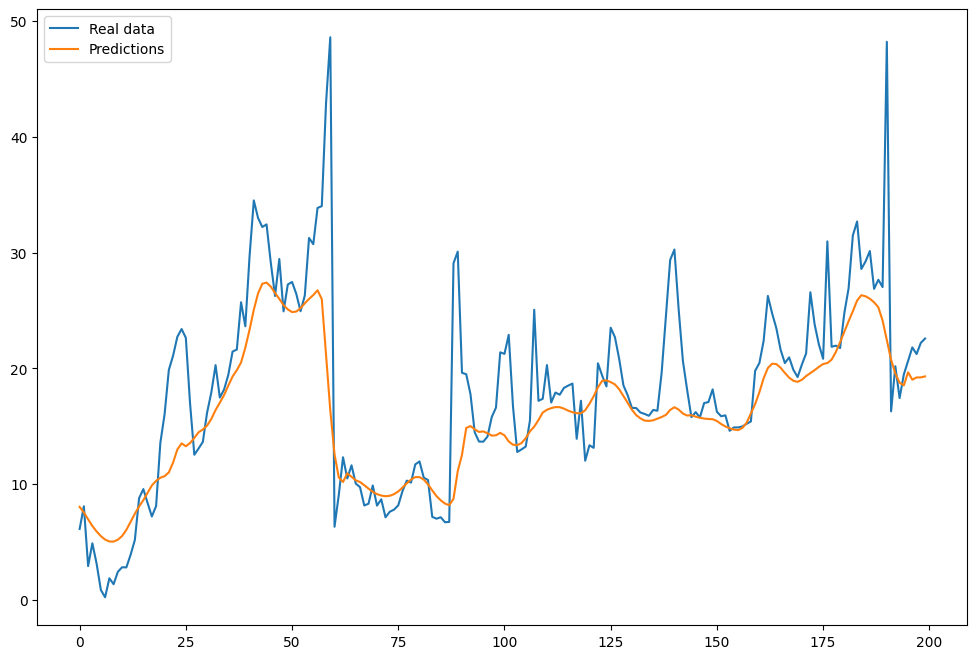

In [115]:
plt.plot(real_data)
plt.plot(y_pred)
plt.legend(['Real data', 'Predictions'])
plt.show()

In [116]:
model2_metrics = dict()
model2_metrics['MAPE'] = mean_absolute_percentage_error(y_pred, real_data)*100
model2_metrics['RMSE'] = math.sqrt(mean_squared_error(y_pred, real_data))
model2_metrics['MAE'] = mean_absolute_error(y_pred, real_data)
model2_metrics

{'MAPE': 22.50480580939083,
 'RMSE': 5.355843049427823,
 'MAE': 3.213000191366119}

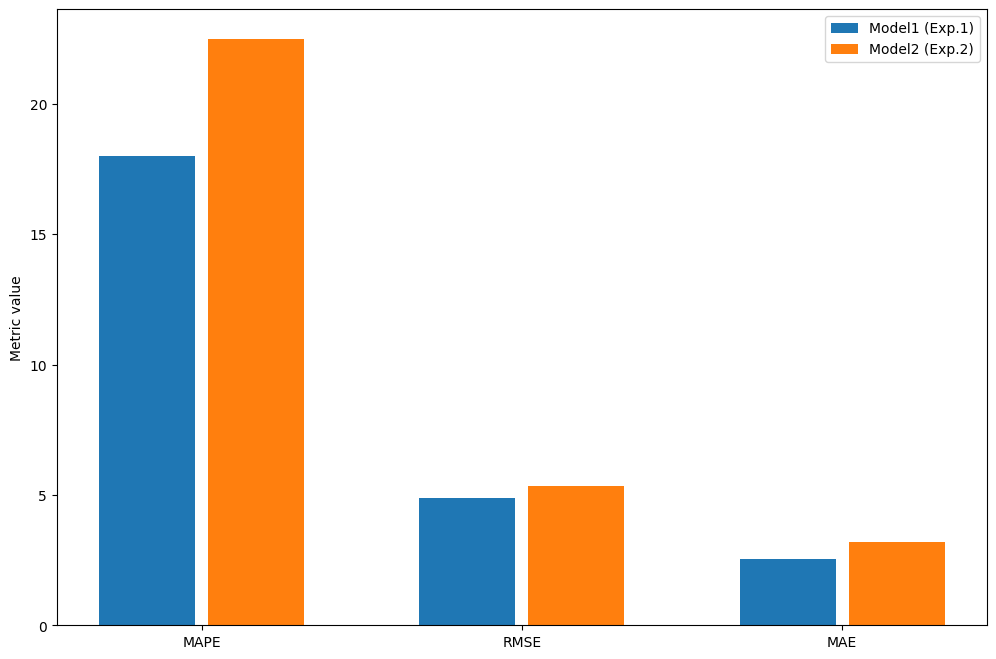

In [126]:
width = 0.3
x = np.arange(len(model1_metrics))

m1 = list(model1_metrics.values())
m2 = list(model2_metrics.values())

plt.ylabel('Metric value')
plt.bar(x-0.17, m1, width, label='Model1 (Exp.1)')
plt.bar(x+0.17, m2, width, label='Model2 (Exp.2)')
plt.xticks(x, labels=model1_metrics.keys())
plt.legend()
plt.show()

In [30]:

df_test = cleaned_training_df[int(len(cleaned_training_df)*0.8):]
df_train = cleaned_training_df[0:int(len(cleaned_training_df)*0.8)]
df_test = df_test[:, :2]
df_train = df_train[:, :2]

look_back = 24
future_n = 1

trainX = []
trainY = []

for i in range(look_back, len(df_train) - future_n + 1):
    trainX.append(df_train[i - look_back: i, 0: df_train.shape[1]])
    trainY.append(df_train[i + future_n - 1: i + future_n, :])

trainX = np.array(trainX)
trainY = np.array(trainY)
print(f'trainX shape: {trainX.shape}; trainY shape: {trainY.shape}')

testX = []
for i in range(look_back, len(df_test)):
    testX.append(df_test[i-look_back: i, 0: df_test.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX shape: (21020, 24, 2); trainY shape: (21020, 1, 2)
testX shape: (5237, 24, 2)


In [37]:
trainY.squeeze().shape

(21020, 2)

In [45]:
model3 = tf.keras.Sequential([
    LSTM(units=64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True),
    LSTM(units=32, activation='relu', return_sequences=False),
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=12, activation='relu'),
    Dense(units=2, activation='softmax')
])
model3.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
history = model3.fit(
    trainX, trainY,
    epochs=30, batch_size=16, validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/30
1183/1183 [==============================] - 14s 10ms/step - loss: 0.0646 - mean_absolute_error: 0.2207 - root_mean_squared_error: 0.2543 - mean_absolute_percentage_error: 96.0596 - val_loss: 0.0652 - val_mean_absolute_error: 0.2228 - val_root_mean_squared_error: 0.2554 - val_mean_absolute_percentage_error: 138.4273
Epoch 2/30
1183/1183 [==============================] - 13s 11ms/step - loss: 0.0646 - mean_absolute_error: 0.2207 - root_mean_squared_error: 0.2542 - mean_absolute_percentage_error: 96.0429 - val_loss: 0.0653 - val_mean_absolute_error: 0.2228 - val_root_mean_squared_error: 0.2556 - val_mean_absolute_percentage_error: 138.4759
Epoch 3/30
1183/1183 [==============================] - 12s 10ms/step - loss: 0.0646 - mean_absolute_error: 0.2207 - root_mean_squared_error: 0.2542 - mean_absolute_percentage_error: 96.0432 - val_loss: 0.0652 - val_mean_absolute_error: 0.2228 - val_root_mean_squared_error: 0.2554 - val_mean_absolute_percentage_error: 138.4126
Epoch 4/30
11

In [46]:
hours_to_predict = 24
past_hours = 200

y_pred = model3.predict(testX[-past_hours:])
print(y_pred.shape)

7/7 [==============================] - 0s 5ms/step
(200, 2)


In [49]:
y_pred = np.repeat(y_pred, 2, axis=-1)
y_pred = scaler.inverse_transform(y_pred)[:,0]

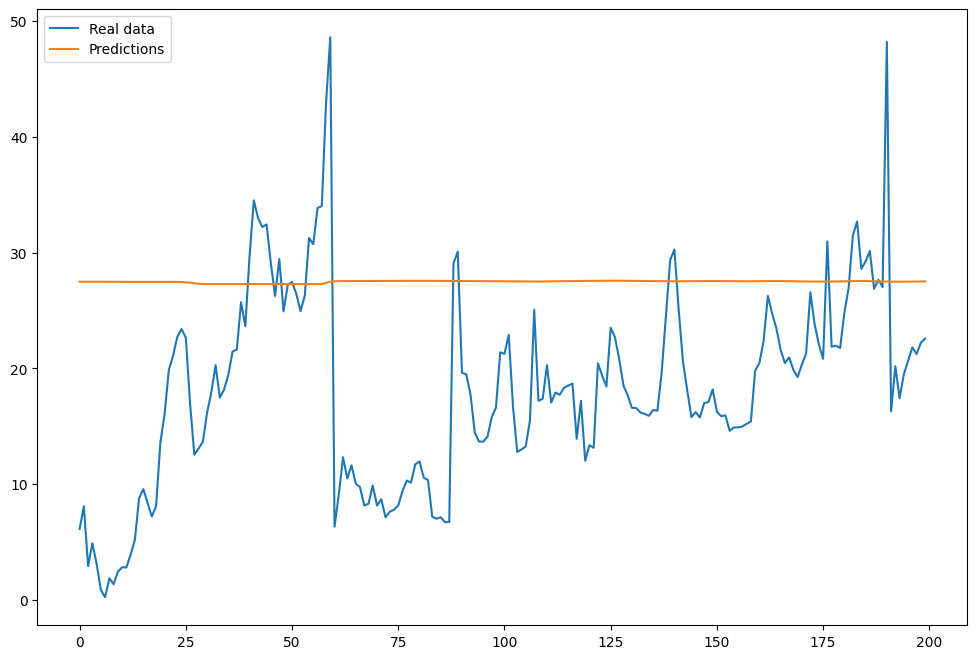

In [50]:
real_data = df_original[int(len(df_original)*0.8):]
real_data = real_data['PM10 Concentration'].to_numpy()[-past_hours:]
plt.plot(real_data)
plt.plot(y_pred)
plt.legend(['Real data', 'Predictions'])
plt.show()